Data source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data


Task: To predict the level of toxicity of the given input comment. 

1, Let's import all the packages that we would require

In [1]:
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation and analysis
import numpy as np
import scipy
import pandas as pd
import math
from collections import Counter

# string manipulation
import re
import string

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# natural Language processing(text processing)
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer

# text processing feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# data splitting and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error

# dimensionality reduction
from sklearn.decomposition import TruncatedSVD, PCA

# regression models
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# deep learning and neural networks
import gensim
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM # No GPU available
from keras.layers import Dropout
from keras.layers import Embedding
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2, Load the data

In [2]:
# reading the train data and using python engine instead of the default 'c'.
# the Python engine is slower but more flexible and can handle a wider range of cases (example: when encountering parsing issues or special characters) compared to the faster C engine 
train_df = pd.read_csv('train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
train_df.columns

Index(['target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

Columns in train data:


* target: values ranging from 0 to 1 (y/prediction column)
* comment_text: data in string format used for further analysis

Additional toxicity subtype attributes: 


* 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat'



Identity attributes:


* 'asian', 'atheist', 'bisexual',
'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
'jewish', 'latino', 'male', 'muslim', 'other_disability',
'other_gender', 'other_race_or_ethnicity', 'other_religion',
'other_sexual_orientation', 'physical_disability',
'psychiatric_or_mental_illness', 'transgender', 'white'


Metadata:


* 'created_date','publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
'sad', 'likes', 'disagree', 'sexual_explicit',
'identity_annotator_count', 'toxicity_annotator_count'





**We will be using only comment_text column to predict**

In [4]:
# generating descriptive statistics 
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [5]:
# generating concise summary
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [6]:
# counting the number of missing values in the dataframe
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

In [7]:
# rows, columns
train_df.shape

(1804874, 44)

3, Exploratory Data Analysis

* Target

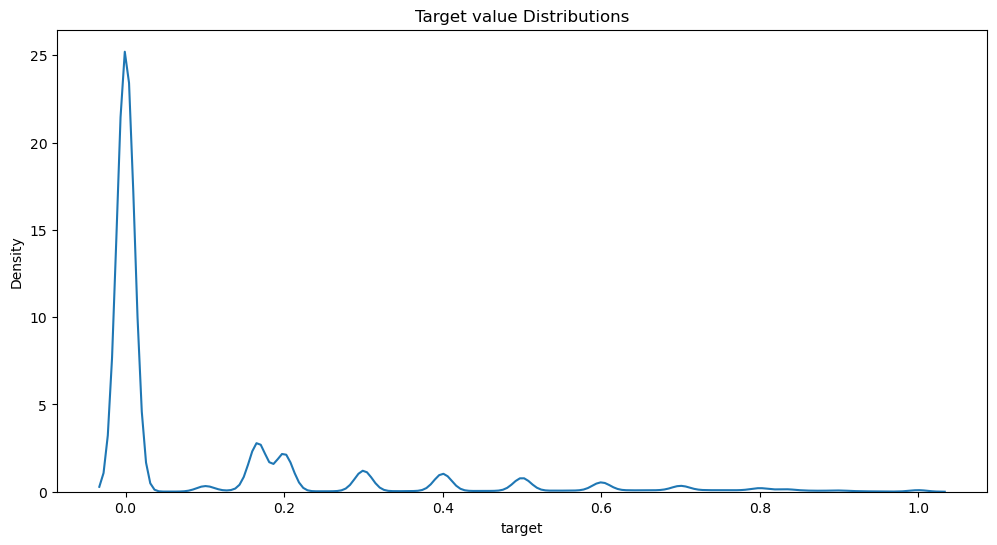

In [8]:
# visualizing the distribution of target column (toxicity values ranging from 0 to 1)
# target vs density

plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

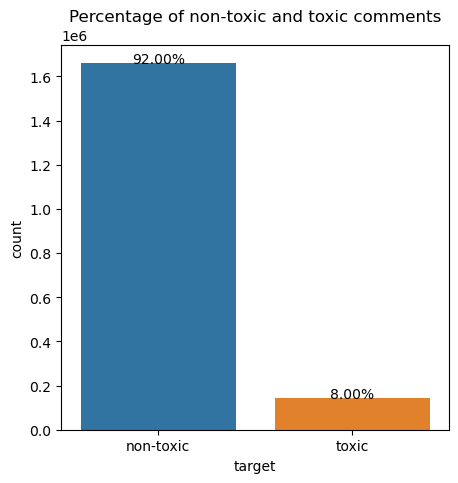

In [9]:
# plotting the number and percentage of toxic and non-toxic comments based on the toxicity rating

# Get toxic and non-toxic comments
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Reset the index of the Series
temp = temp.reset_index(drop=True)

# Plot
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Define the order of categories
order = ['non-toxic', 'toxic']

# Plot the count plot
cntplot = sns.countplot(x=temp, order=order)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it on the plot itself
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(percentage), ha='center')

plt.show()

**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

* Additional attributes within toxicity

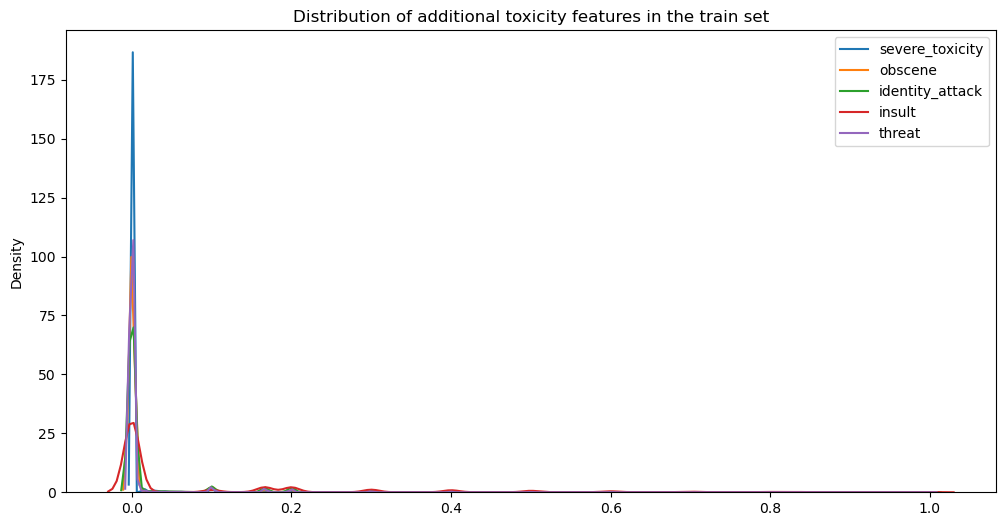

In [10]:
# visualizing the distribution of additional subtypes within toxicity 

features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
title = "Distribution of additional toxicity features in the train set"

plt.figure(figsize=(12,6))
plt.title(title)
for feature in features:
    sns.distplot(train_df[feature], kde=True, hist=False, bins=240, label=feature) # plots the kernel density estimation curve of the normalized data (meaning AUC will add upto 1)
plt.xlabel('') 
plt.legend()
plt.show()

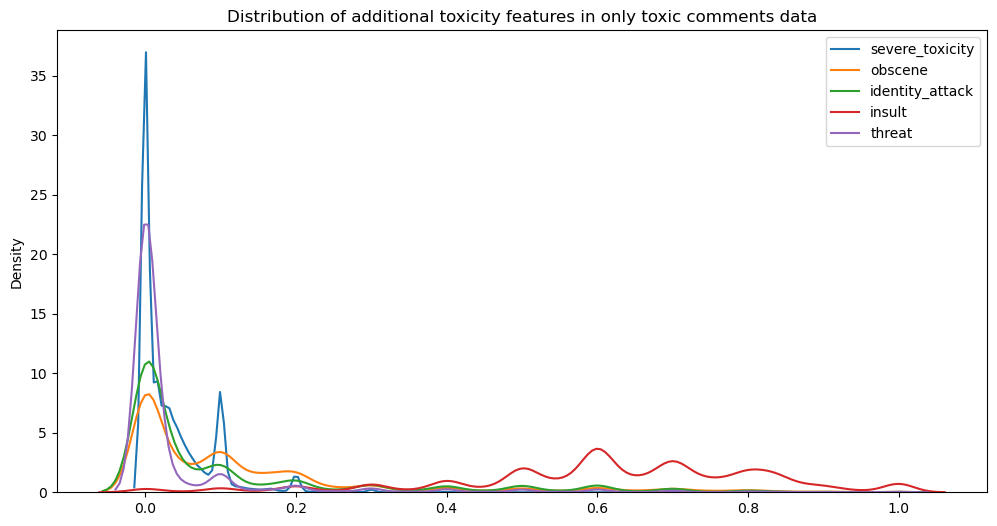

In [11]:
# visualizing the distribution of additional subtypes within toxicity but taking only comments that are actually considered toxic, i.e., the values in target column are greater than 0.5

temp = train_df[train_df['target'] > 0.5]
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
title = "Distribution of additional toxicity features in only toxic comments data"

plt.figure(figsize=(12,6))
plt.title(title)
for feature in features:
    sns.distplot(temp[feature], kde=True, hist=False, bins=240, label=feature)
plt.xlabel('')
plt.legend()
plt.show()

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [12]:
# Defining a function to determine the nature of each toxic comment based on the additional toxicity features
# It calculates the maximum value among the features 'severe_toxicity', 'obscene', 'identity_attack', 'insult', and 'threat' for each comment
# Then, it returns the corresponding nature of toxicity based on the feature with the highest value
# The function is applied to each row of the DataFrame temp, which contains only the comments that are considered toxic.
# The resulting Series x contains the nature of toxicity for each toxic comment.

# defining the function
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

In [13]:
# analyzing the nature of the toxic comments using the predefined function
x = temp.apply(get_comment_nature, axis=1)
x

id
59856       insult
59859      obscene
239583      insult
239607      insult
239612      insult
            ...   
6333775     insult
6333841     insult
6333871     insult
6333927    obscene
6334009     insult
Length: 106438, dtype: object

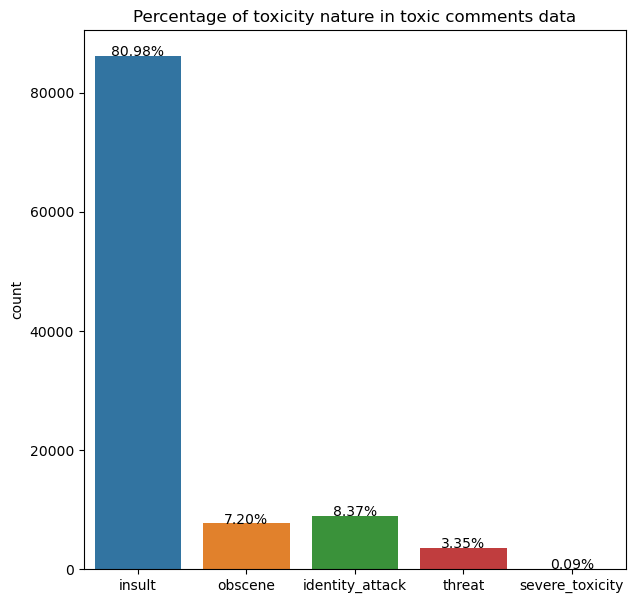

In [14]:
# visualizing the distribution of different types of toxicity
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# creating a count plot to visualize the distribution of different types of toxicity
cntplot = sns.countplot(x=x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    percentage = 100 * height / total
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(percentage), ha='center') # The height of each bar represents the count of comments corresponding to a specific nature of toxicity
    
plt.show()

**Within the 8% of toxic data, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic**

* Identity attributes

In [15]:
# dropping all the nan values and saving the original datafrme into temp
temp = train_df.dropna(axis = 0, how = 'any')

In [16]:
# defining a function to plot the distribution of multiple features in a dataset
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

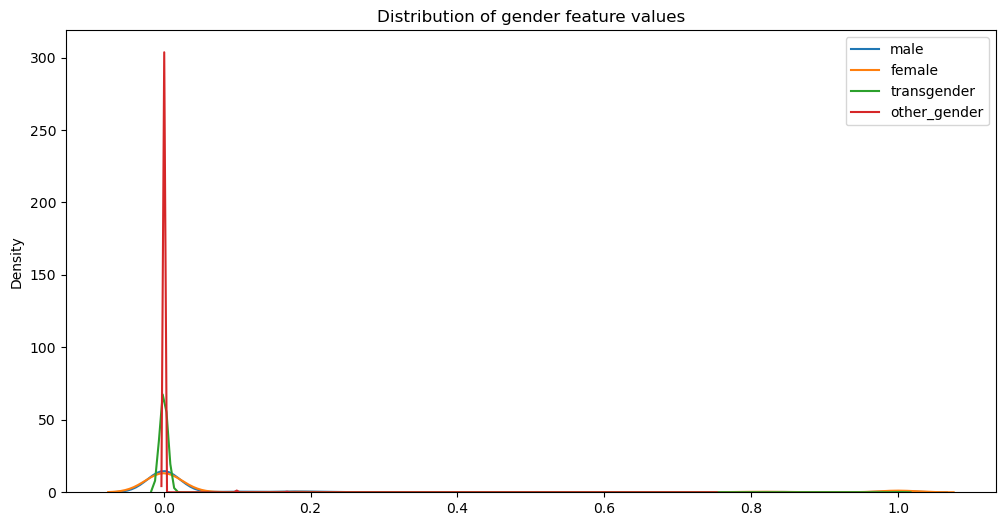

In [17]:
# visualizing the distribution of different gender attributes

features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

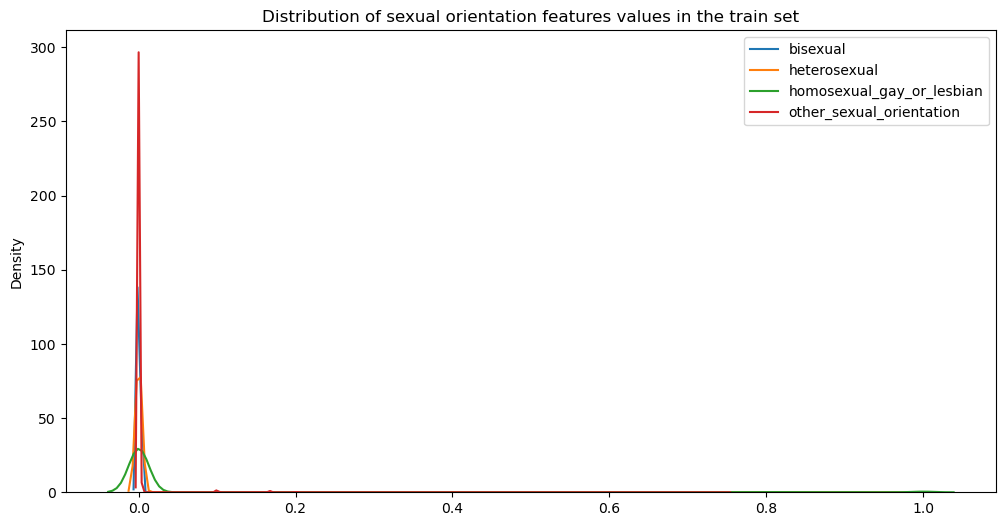

In [18]:
# visualizing the distribution of different sexual orientation attributes

features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

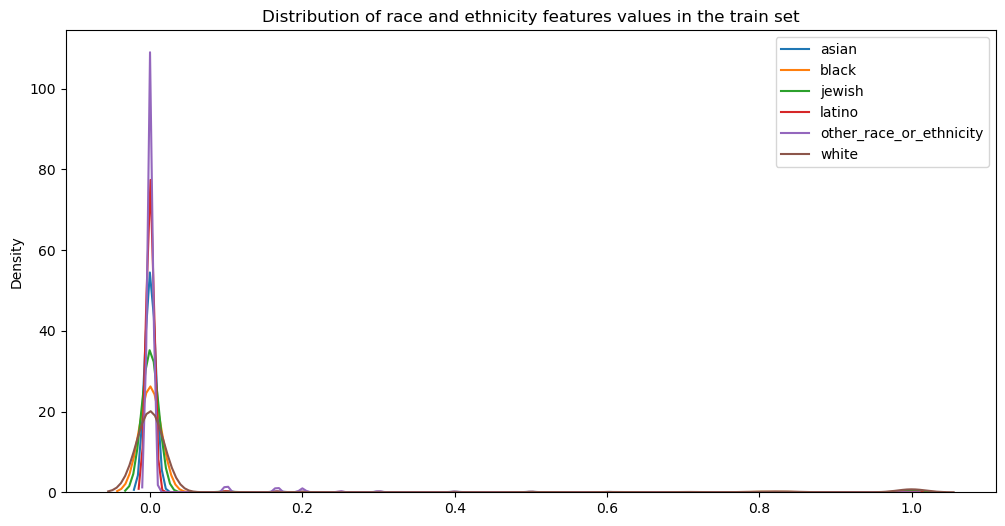

In [19]:
# visualizing the distribution of different races and ethnicities in the dataset

features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

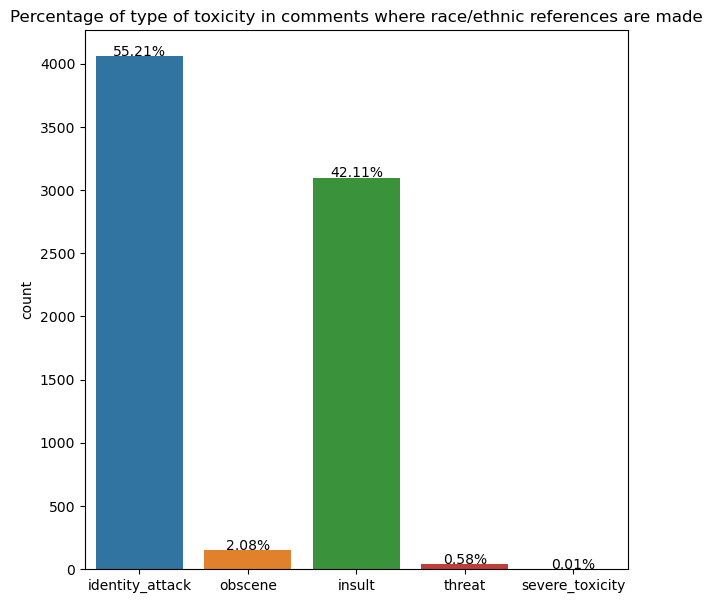

In [20]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x = x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself
for p in ax.patches:
    # Get height.
    height = p.get_height()
    percentage = 100 * height / total
    # Plot at appropriate position
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(percentage), ha='center')

plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

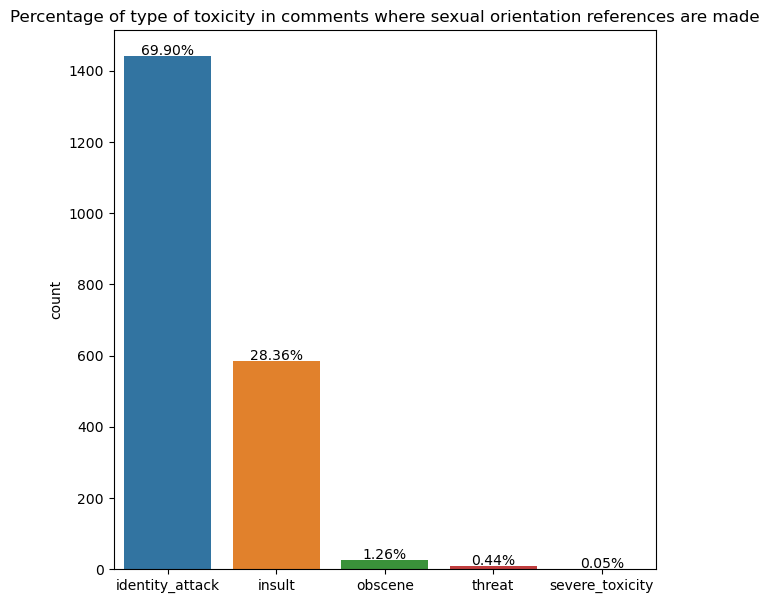

In [21]:
# Get data where race/ethnic references are made 
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x = x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

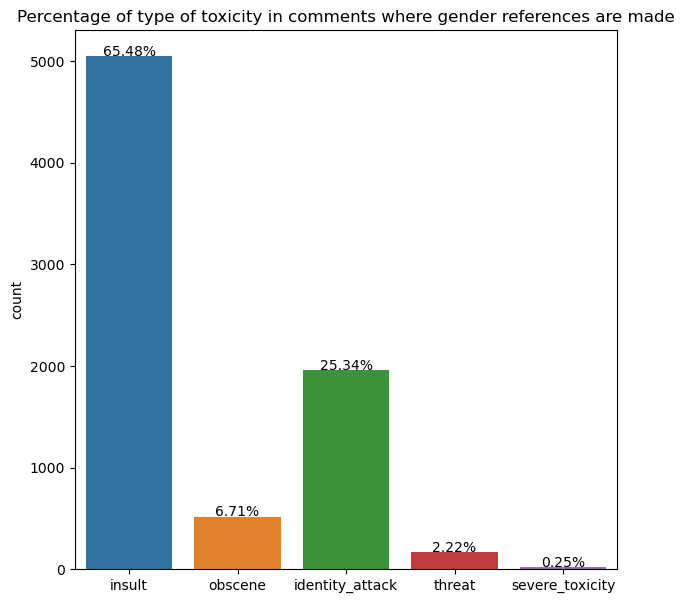

In [22]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x = x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

* User feedback

In [23]:
# defining a function to create a count plot for the features in the dataset.
#The function plots the count of each category in the specified feature, orders the bars based on the count of each category, 
# and adds percentage labels to each bar indicating the percentage of data points represented by that category.


def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(x = data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()  

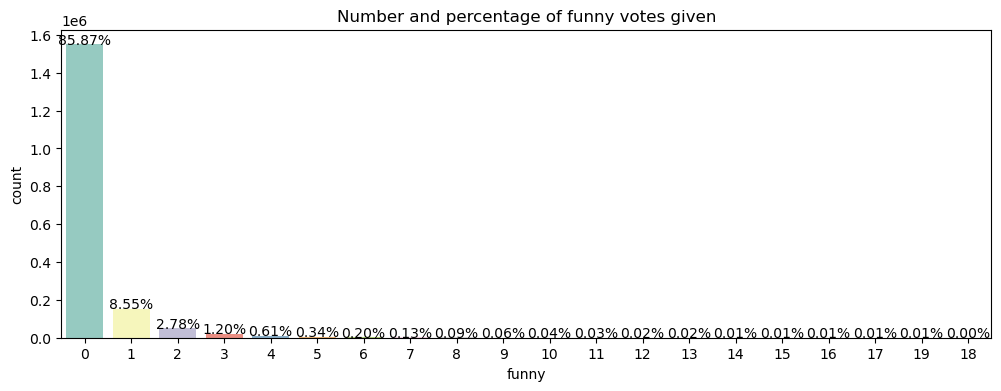

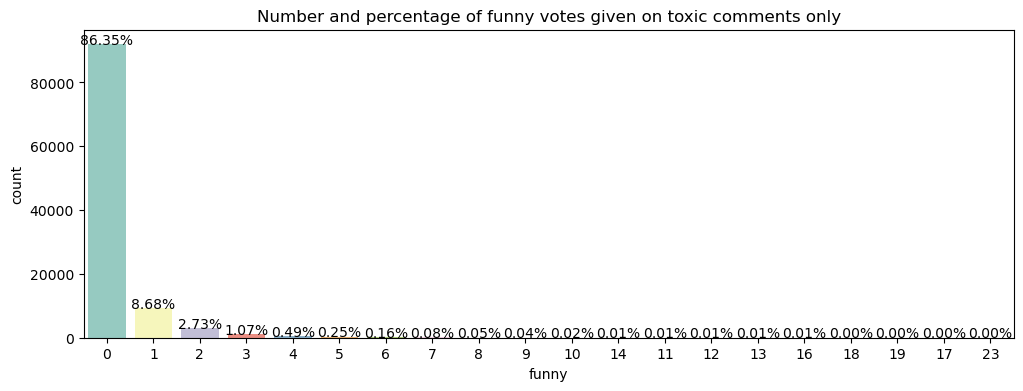

In [24]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

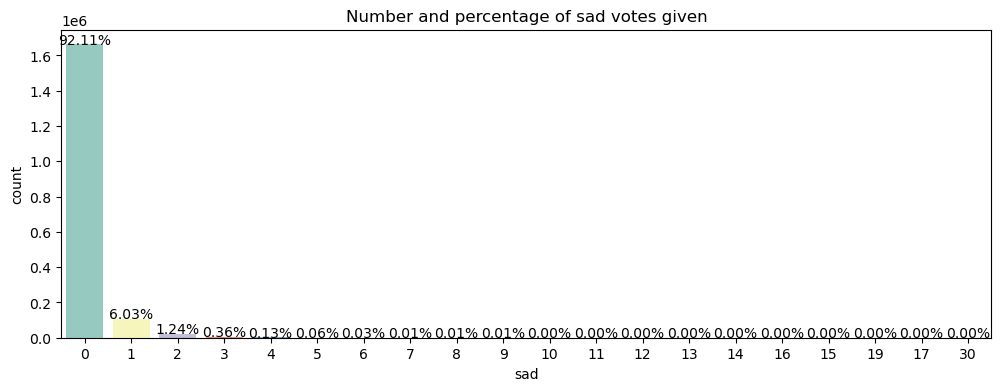

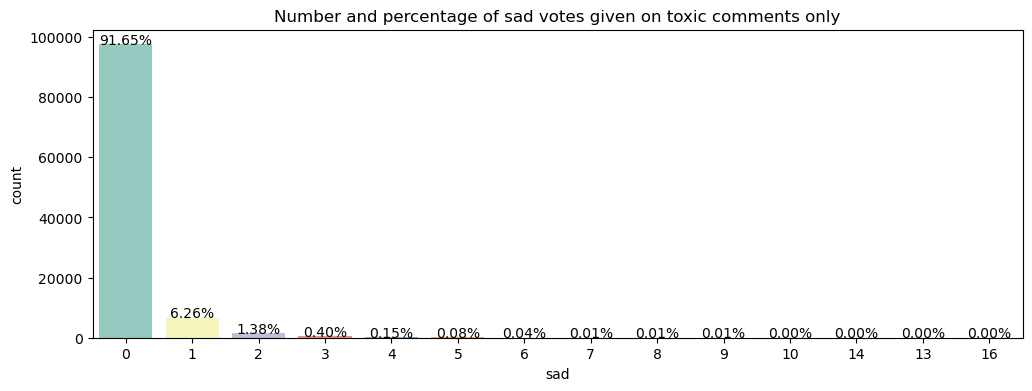

In [25]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

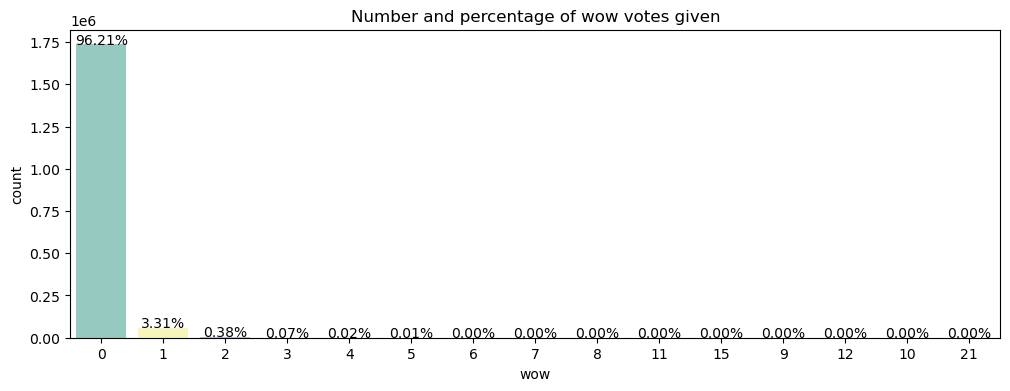

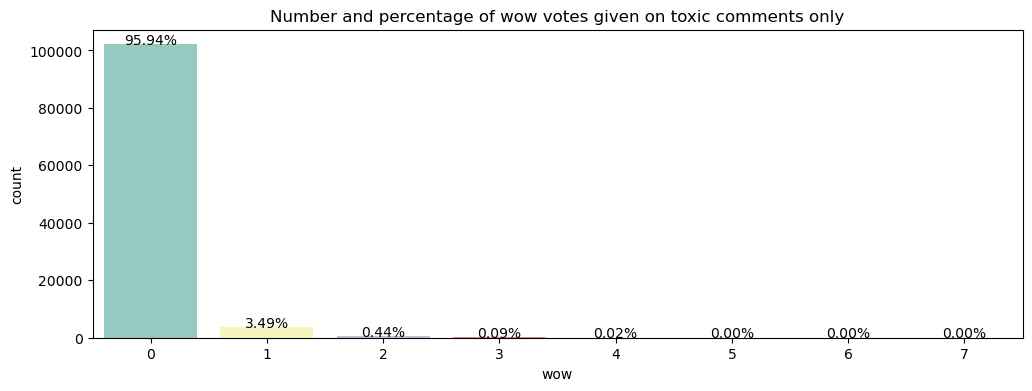

In [26]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

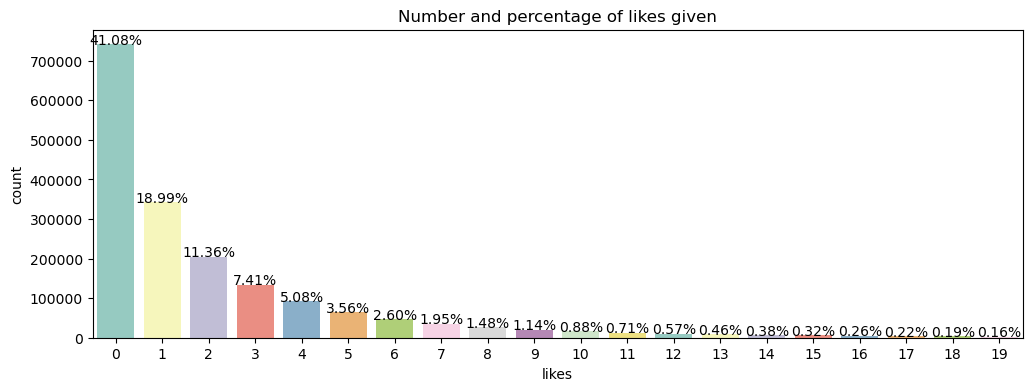

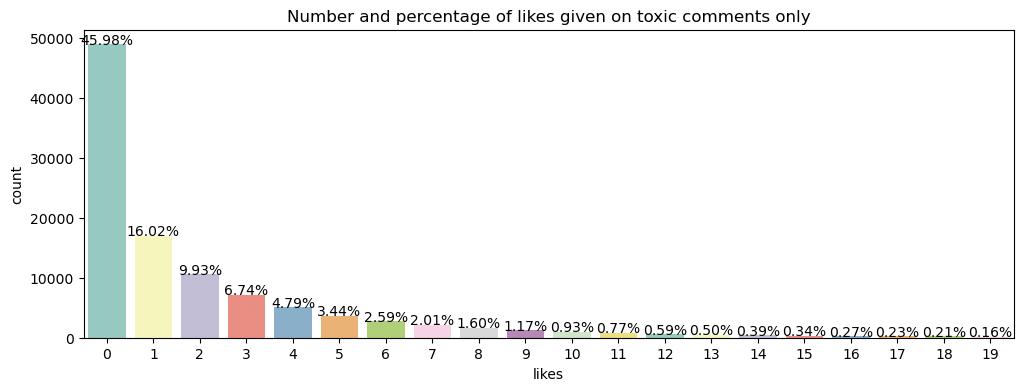

In [27]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

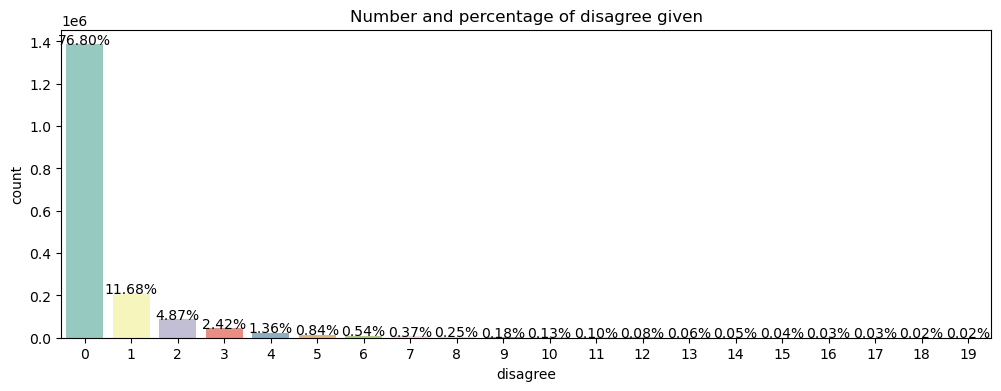

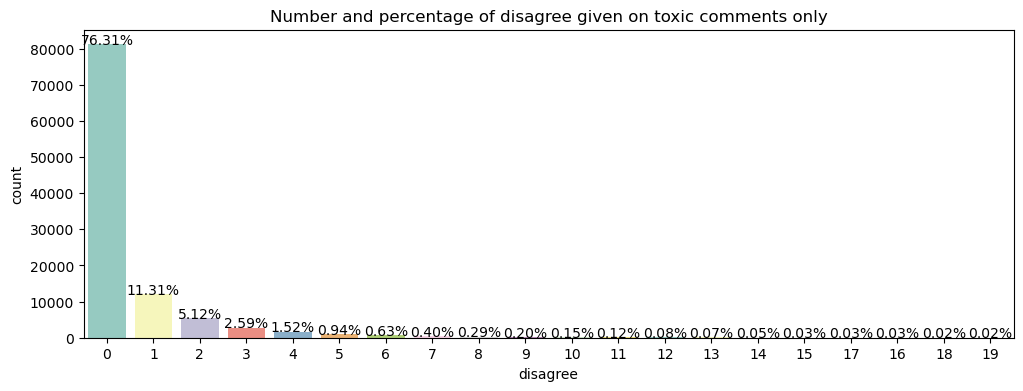

In [28]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

* Comments data wordclouds

wordcloud of frequent used words in the comments. A maximum of 50 words are shown.

In [29]:
# importing stopwords from the word cloud library
stpwrds = set(STOPWORDS)

# defining a function to generate and display a word cloud
def show_wordcloud(data, title = None):
    
    # generating a wordcloud with a specified parameters
    wordcloud = WordCloud(
        background_color='white', # setting the background color to white
        stopwords=stpwrds, # using predefined stopworss to ignore common words
        max_words=50, # setting the maximum number of words to be displayed to 50
        max_font_size=40,
        scale=5, # scaling factor for the word cloud (increases or decreases the size of the word cloud image without affecting the relative sizes of individual words)
        random_state=1 # Setting the random state for reproducibility
    ).generate(str(data)) # Generating the word cloud based on the input data converted to a string

    fig = plt.figure(1, figsize=(10,10))
    
    # Turning off the axis to remove the axis labels
    plt.axis('off')
    
    # Adding a title to the plot if a title is provided
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

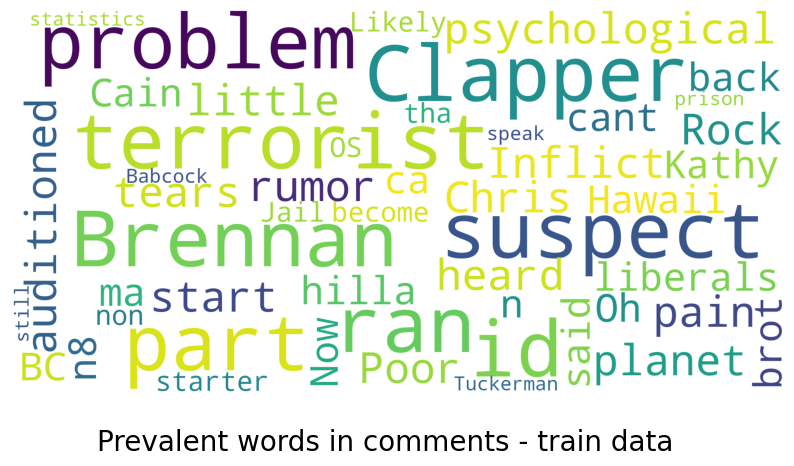

In [30]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

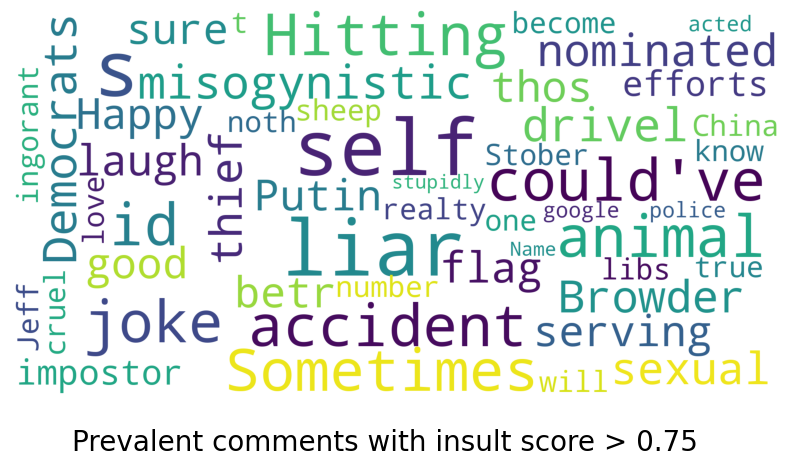

In [31]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

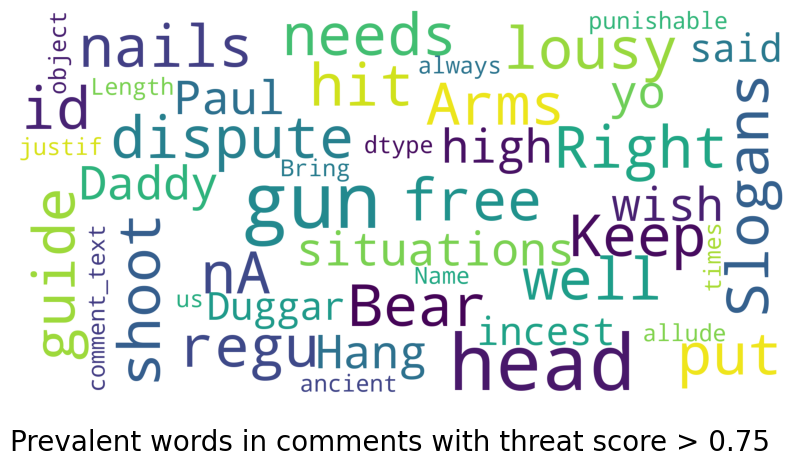

In [32]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

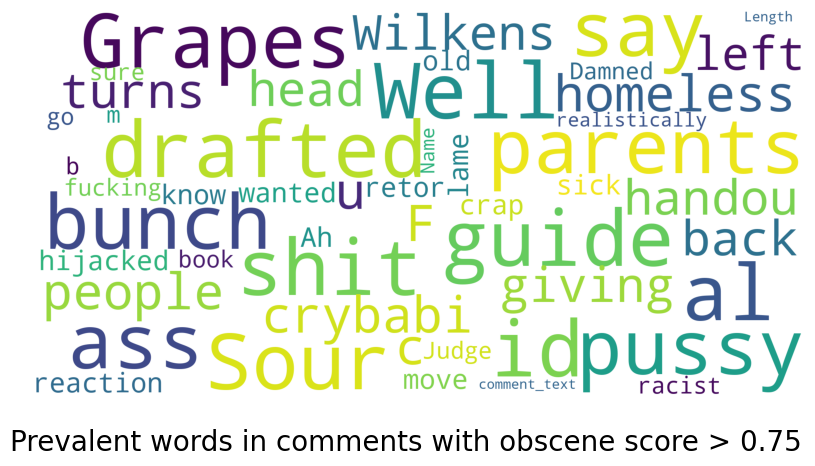

In [33]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

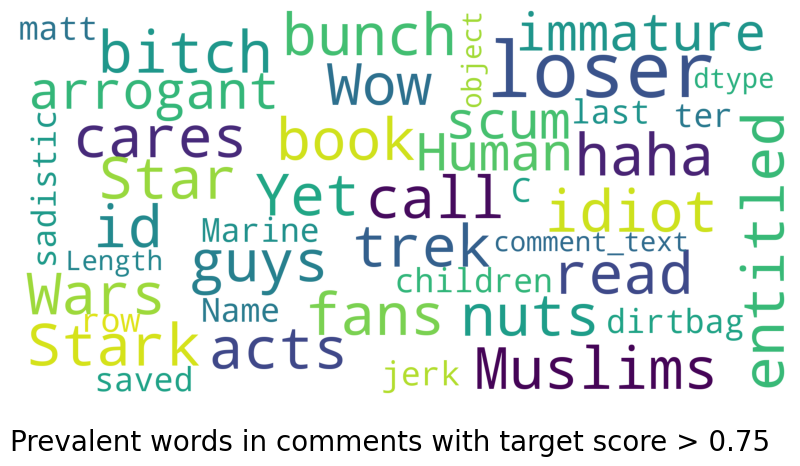

In [34]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

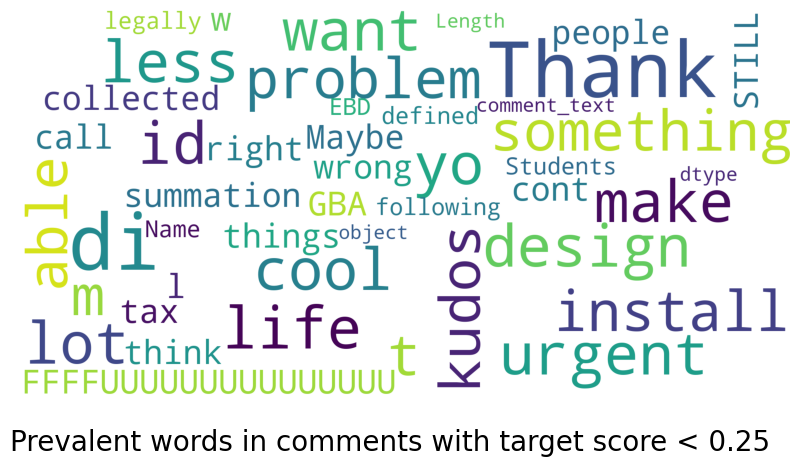

In [35]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

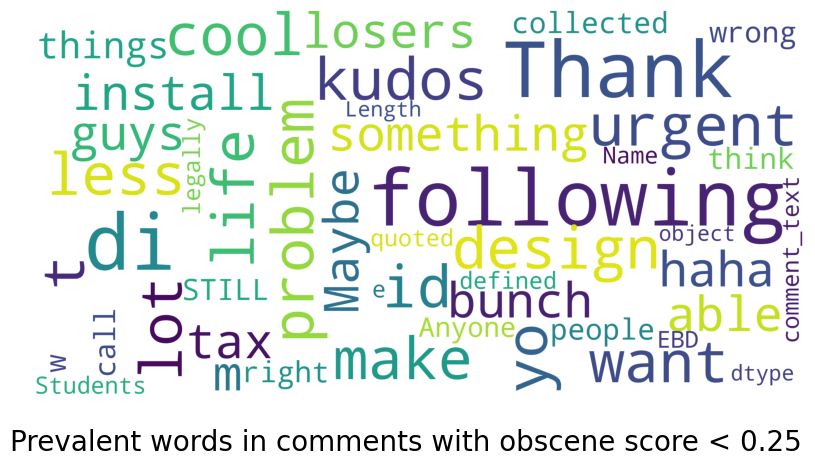

In [36]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

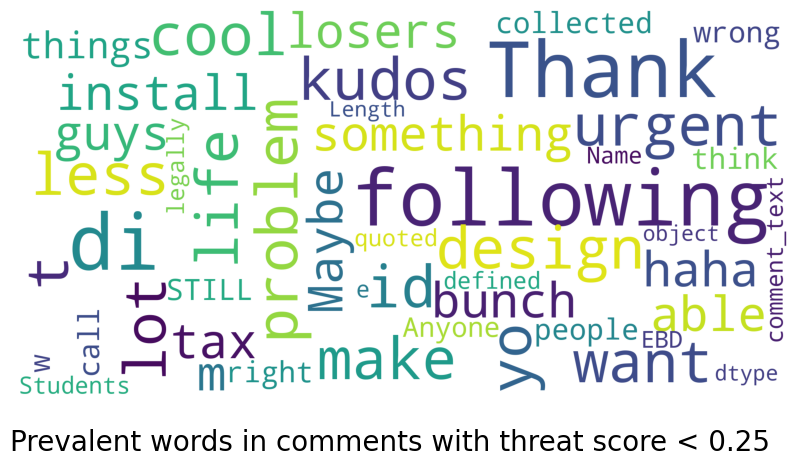

In [37]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

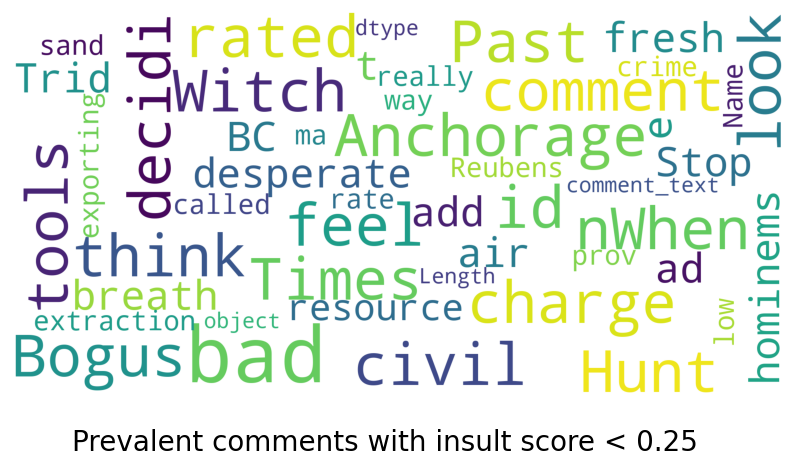

In [38]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

load test data

In [39]:
# reading the test data 
test_df = pd.read_csv('test.csv', index_col='id', engine='python')
print("Test dataframe shape:", test_df.shape)
test_df.head()

Test dataframe shape: (97320, 1)


,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


3, Preprocessing

In [40]:
# importing the SnowballStemmer class from the nltk.stem module
stemmer = SnowballStemmer("english")

# Creating a set of stopwords using the English stopwords provided by nltk
stop_words = set(stopwords.words('english'))

# defining a function to preprocess the text
def preprocess(text_string):
    text_string = text_string.lower() # converting everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string)  # removing special characters and punctuations
    x = text_string.split() # splitting the text into individual words
    
    new_text = [] # Initialize an empty list to store the stemmed words
    
    # iterating over each word after splitting the text
    for word in x:
        if word not in stop_words: # if the word not in stop_words
            new_text.append(stemmer.stem(word)) #Stem the word using the SnowballStemmer and add it to the list of stemmed words
    
    # joining the stemmed words back into a single string        
    text_string = ' '.join(new_text)
    
    # returns the preprocessed text
    return text_string

# Here we removed stop words/common words like "the" "is" "and" as they donot provide much useful information
# and they can add npise and increase computational complexity to the model

In [41]:
%%time
# applying the predefined function to the comment_text column from training data
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: total: 8min 45s
Wall time: 10min 53s


In [42]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [43]:
%%time
# applying the predefined function to the comment_text column from test data
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: total: 26.8 s
Wall time: 35.4 s


4, Train-test split

In [44]:
# splitting the data into train and test

feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [45]:
X_train.head()

,preprocessed_text
id,
1010418,argument base entir anecdot evid mean weak far...
5323642,sorri feel way
5001836,thank god close road come
5770407,happi busi leader stand bigot presid time repu...
342769,understand peopl liter money pay rent usual op...


In [46]:
X_cv.head()

,preprocessed_text
id,
1030405,face option continu servic disloyalti offic mu...
5020822,odd articl post confirm stori way shape form g...
6202642,mayb weinstein apolog
5004234,impress univers drink cultur though attend 80s...
858849,citizen honolulu want better govern demand rig...


In [47]:
# test data from the test.csv file
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [48]:
# Saving the data to pickle files so that we dont need to preprocess again.

# pickling is used to serialize and deserialize python objects. 
# serialization converts the object to byte stream, this allows us to store complex data structures and load them back into memory later.

X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

5, Model development

In [49]:
# To load the pickle files:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

*Bag of words*

- A very common feature extraction procedures for sentences and documents is the bag-of-words approach (BOW).
- It is the vector representation of text data that describes the occurence of words within a document.
- it disregards grammar and word order, hence "bag"
- It represents each document as a vector where each element corresponds to the frequency of a word in a predefined vocabulary.

In [50]:
# before creating BoW, text data needs to be tokenized into individual words or tokens
# CountVectorizer from sklearn, converts text to matrix of token counts.
# ngram_range spicifies both unigrams and bigrams should be considered as features 
# we use bigrams when the unigrams does not have any meaning
# Max features, keeps only the most frequent terms in the vocalbulary
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)

# fitting the countvectorizer to the training data
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])

# Transforming the preprocessed text data into a bag-of-words representation
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


*Stochastic Gradient Descent Regressor* {ML}


- It is a linear regression model that is optimized using stochastic gradient descent optimization technique. 
- It is particularly suitable to large scale regression problems, with very large number of samples (observations) / features (variables).
- Similar to other linear regression models, SGDRegressor aims to learn the weights (coefficients) that minimize the mean squared error (MSE) between the predicted and actual target values.
- The algorithm starts with random initialization of coefficients and iteratively updates them to minimize the loss function.
- Unlike batch gradient descent, which computes the gradient of the loss function using the entire dataset, SGDRegressor computes the gradient using only one data point (or a small batch) at a time. 
- For each iteration of the training data, the data is shuffled and divided into mini-batches. 
- For each mini batch the loss function is computed and the parameters are updated to minimize the loss function. 
- This optimization occurs till convergence is met or until it reaches a predefined number of epochs.
- SGDRegressor supports various regularization techniques such as L1 (Lasso) and L2 (Ridge) regularization, which help prevent overfitting by penalizing large coefficients.
- The hyperparameters of SGDRegressor include:

        - alpha: The regularization strength, which controls the amount of regularization applied to the model.
        - penalty: The type of regularization (L1 or L2).
        - learning_rate: The learning rate, which determines the step size for updating the coefficients during optimization.


In [51]:
# Hyper parameter tuning

# define the range of values for hyperparameters alpha and penalty
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']

# Initialize lists to store alpha values and corresponding errors for training and cross-validation sets
xticks = [] # store combinations of alpha and penalty for plotting
tr_errors = [] # store mean squred errors
cv_errors = [] # store mean squred errors

# Initialize variables to keep track of the best model and its error
best_model = None
best_error = 100

# Loop through each combination of alpha and penalty
for a in alpha:
    for p in penalty:
        
        # Create a string representation of the combination for x-axis labeling
        xticks.append(str(a) + ' ' + p)
        # Print the combination of alpha and penalty
        print(str(a) + ' ' + p + " :")
        
        # Initialize the SGDRegressor model with the current alpha and penalty
        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(bow_train, y_train) # Train the model on the bag-of-words training set 
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate the mean squared error on the training set
        tr_errors.append(err) # Append the error to the list of training errors
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err) # Append the error to the list of training errors
        print("Mean Squared Error on cv set: ", err)
        
        # Update the best model and its error if the current error is lower
        if err < best_error: 
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.023127285248644394
Mean Squared Error on cv set:  0.02300939256888506
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  1.5695145721661916
Mean Squared Error on cv set:  0.6650578294704738
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024457312901336622
Mean Squared Error on cv set:  0.024555518837099687
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.688952657599709
Mean Squared Error on cv set:  0.04358634278820224
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.031429437736638775
Mean Squared Error on cv set:  0.03163637690437456
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.024540808678426198
Mean Squared Error on cv set:  0.02359350533100695
**********************************************

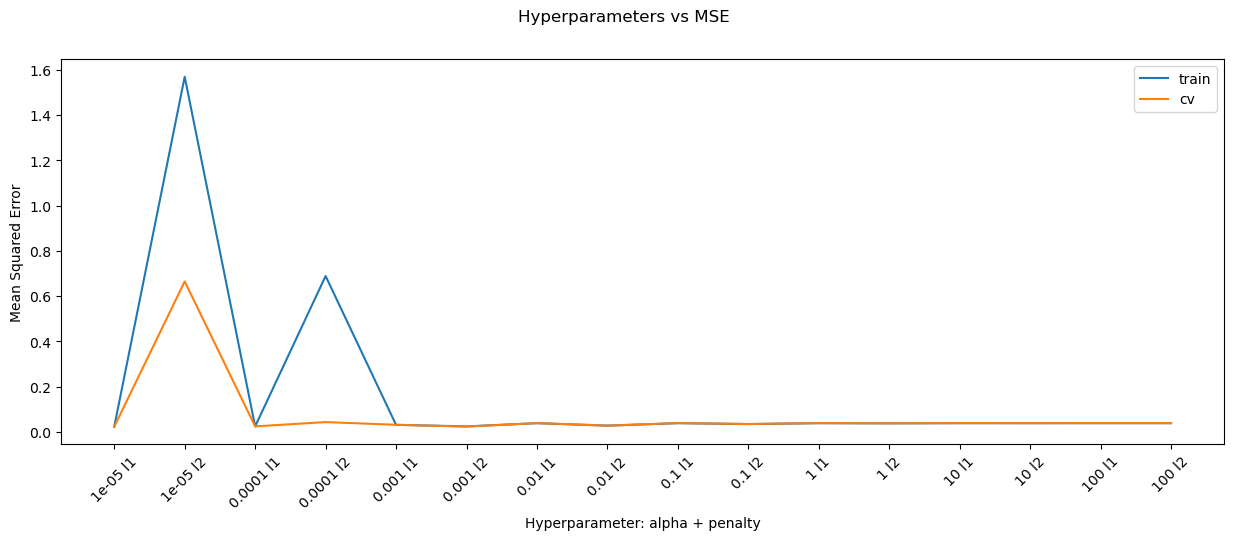

In [52]:
# Plotting the relationship between hyperparameters (combination of alpha and penalty) and mean squared error(MSE) of the model

plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [53]:
# Getting the "best" model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

* Feature Importance

Feature importance is the technique used to determine the relative importance of each feature (x/independent variable) in predicting the target variable (y/dependent variable) in a machine learning model. 

It provides insights into which features have the most significant impact on the model's predictions and helps in understanding the underlying relationships between features and the target.

In [54]:
# Printing the 20 most important features/words which contribute to a comment being toxic.

# Retrieving feature names from CountVectorizer
feat_names = cnt_vec.get_feature_names_out()

# Retrieving coefficients (weights) from the best-trained model
weights = best_model.coef_

# Creating a DataFrame to store feature names and their corresponding weights
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)

# Sorting the DataFrame by weights in descending order and selecting the top 20 most important features
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.420823
stupid,0.339397
moron,0.320319
pathet,0.297503
crap,0.282414
hypocrit,0.277838
ass,0.275335
scum,0.265159
jerk,0.264198
dumb,0.263198


In [55]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
stupid stupid,-0.135026
left left,-0.074800
knee jerk,-0.067887
black white,-0.049933
fool peopl,-0.045089
ignor fact,-0.039251
winner loser,-0.035696
dumb dumb,-0.033184
black market,-0.030793
white hous,-0.029282


*Decision Tree* {ML}

- It is structured like a tree, with a root node, internal node and leaf nodes.
- The algorithm starts at the root node and makes decisions based on the features values and split the data into subsets.
- Each internal node represents a decision based on a feature and each branch represents the outcome of that decision.
- The process of splitting the data continues recursively until a stopping criterion is met.
- This could be when all instances in a node belong to the same class (for classification) or when the node contains a minimum number of instances (for regression).
- Once the splitting process is complete, the final nodes are called leaf nodes, and they represent the predicted outcome. 
- For classification tasks, each leaf node corresponds to a class label, while for regression tasks, each leaf node contains a predicted numerical value.
- When splitting a node, the algorithm considers all possible splits and selects the one that results in the best separation of the target variable.
- Decision trees are prone to overfitting, especially when the tree is allowed to grow too deep. Techniques like pruning (removing unnecessary branches) and setting constraints on tree depth (max_depth) or minimum samples per leaf can help prevent overfitting.

In [56]:
# Performing hyperparameter tuning:

# Defining hyperparameter ranges
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]

# Initializing lists to store results
xticks = [] # Stores labels for x-axis
tr_errors = [] # Stores training set errors
cv_errors = []  # Stores cross-validation set errors 

# Initializing variables for best model selection
best_model = None
best_error = 100

# Looping over each combination of hyperparameters
for d in max_depth:
    for samp in min_samples:
        
        # Generating label for the combination of hyperparameters
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        # Creating a decision tree regressor model with current hyperparameters
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Training the model
        
        # Calculating Mean Squared Error (MSE) on the training set
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err) # Append the error to the list of training errors
        print("Mean Squared Error on train set: ", err)
        
        # Calculating Mean Squared Error (MSE) on the cross-validation set
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err) # Append the error to the list of cross validation errors
        print("Mean Squared Error on cv set: ", err)
        
        # Updating the best model if the current error is lower
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.033044993670485204
Mean Squared Error on cv set:  0.033304629773392214
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0330449936704852
Mean Squared Error on cv set:  0.03330462977339221
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03304689698769661
Mean Squared Error on cv set:  0.033306473273587156
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03197011740109232
Mean Squared Error on cv set:  0.032196675870186126
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.031973459643401106
Mean Squared Error on cv set:  0.032195691739048835
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on t

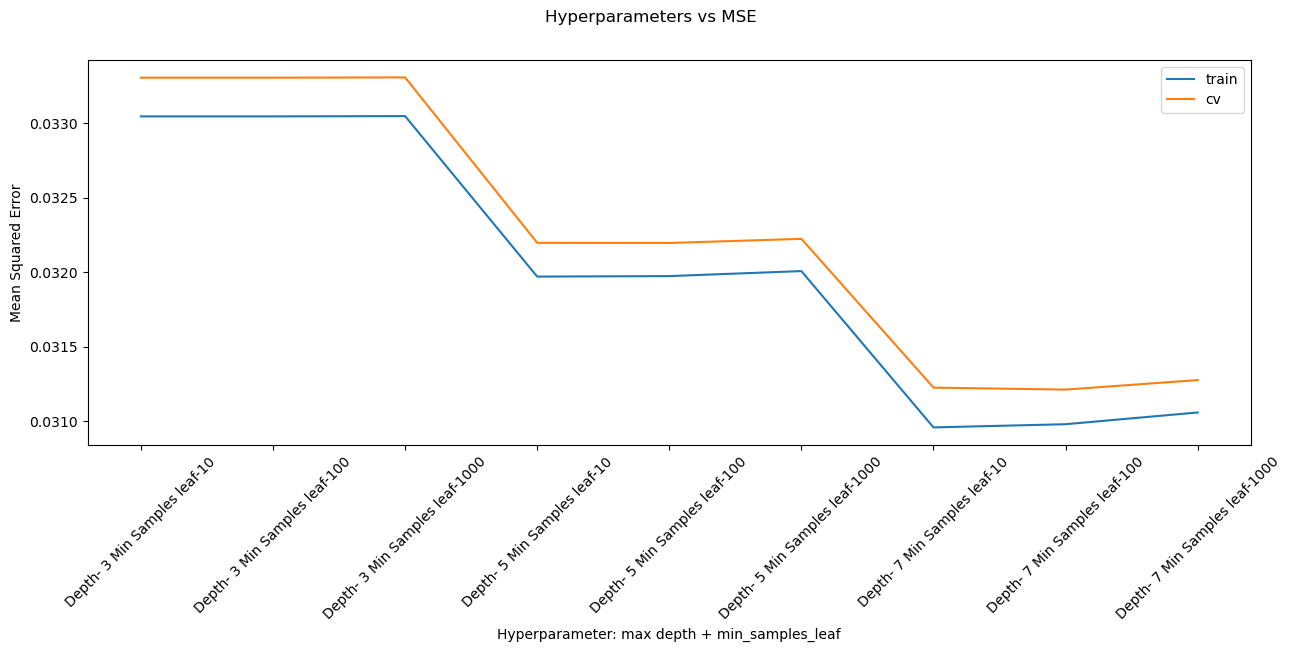

In [57]:
# plot to visualize the relationship between hyperparameters and Mean Squared Error (MSE) for both the training and cross-validation sets.

plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [58]:
# Getting the "best" model parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

* feature importance

In [59]:
# Retrieving feature importances from the best-trained model
weights = best_model.feature_importances_

# Creating a DataFrame to store feature names and their corresponding feature importances
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)

# Sorting the DataFrame by feature importances in descending order and selecting the top 20 most important features
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.394338
idiot,0.264408
fool,0.069114
pathet,0.067318
moron,0.063571
white,0.059319
hypocrit,0.056792
racist,0.005527
would,0.003699
one,0.003501


*Term Frequency - Inverse Document Frequency (TFIDF)*

- Term Frequency-Inverse Document Frequency (TF-IDF) is a commonly used technique in natural language processing (NLP) for representing text data.
- Unlike bag-of-words (BoW) approach, TF-IDF considers not only the frequency of occurrence of each word in a document but also each word's importance in the entire corpus.
- It assigns weights to terms based on their frequency within a document (Term Frequency) and their rarity across all documents in the corpus (Inverse Document Frequency).
- The "Term Frequency" component measures how often a term appears in a document. 
- It is calculated as the ratio of the number of occurrences of a term to the total number of terms in the document.
- The "Inverse Document Frequency" component measures how unique or rare a term is across all documents in the corpus. 
- It is calculated as the log of the ratio of the total number of documents to the number of documents containing the term.
- TF-IDF is beneficial because it downweights common terms that occur frequently in many documents and upweights rare terms that are more discriminative.
- TF-IDF vectors represent each document as a vector where each element corresponds to the TF-IDF weight of a term in the document.
- It provides a more informative representation compared to BoW as it captures both the local and global importance of terms in documents.
- It is mostly used in tasks such as text classification, information retrieval, and document clustering.

In [60]:
# Initializing a TF-IDF Vectorizer with the specified parameters
# ngram_range: specifies the range of n-grams to consider. An n-gram is a sequence of n items from a given sample of text. 
# For example, (1, 2) means it considers both unigrams (single words) and bigrams (sequences of two words).
# max_features: the maximum number of features (unique words or n-grams) to be included in the vocabulary. 
# If there are more unique features in the text data than this value, only the most frequent ones will be kept.
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)

# Fit and transform the training text data to TF-IDF representation
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])

# Transform the cross-validation and test text data to TF-IDF representation using the same vocabulary as the training data
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


*Stochastic Gradient Descent Regression*

In [61]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.025251268927589467
Mean Squared Error on cv set:  0.02542006060137754
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.0238869769150392
Mean Squared Error on cv set:  0.024085504460838274
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.029710710227181913
Mean Squared Error on cv set:  0.029923594049529212
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.025003671757831303
Mean Squared Error on cv set:  0.025216452392741312
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03823148217010502
Mean Squared Error on cv set:  0.03864868670515926
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030017033149743022
Mean Squared Error on cv set:  0.030314199534218565
****************************************

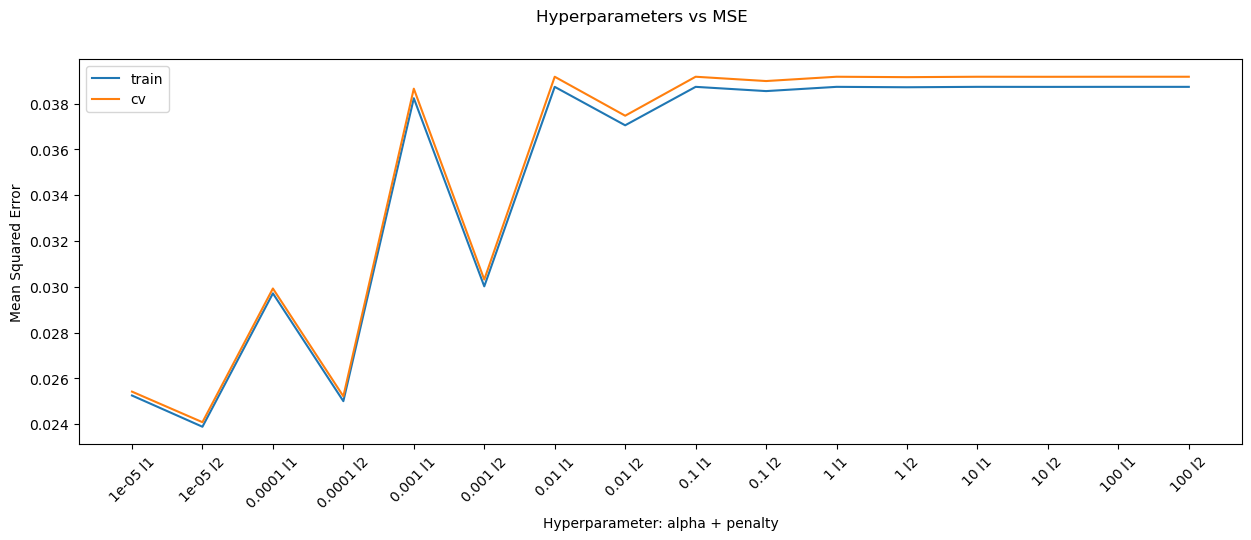

In [62]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

*Feature Importance*

In [63]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.560798
idiot,1.261110
fool,0.660759
ignor,0.603616
dumb,0.598313
pathet,0.584312
moron,0.569908
loser,0.558237
ridicul,0.555152
liar,0.520520


In [64]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.095059
interest,-0.086161
stori,-0.078985
agre,-0.077581
great,-0.072473
may,-0.071487
good,-0.067094
differ,-0.067029
new,-0.066731
point,-0.066212


*Decision Tree*

In [65]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :


Mean Squared Error on train set:  0.03283949178501874
Mean Squared Error on cv set:  0.03309098619900013
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03283949178501876
Mean Squared Error on cv set:  0.03309098619900014
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03283949178501876
Mean Squared Error on cv set:  0.03309098619900014
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03171161362229856
Mean Squared Error on cv set:  0.031931029619859115
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03171347804638325
Mean Squared Error on cv set:  0.031930520980069974
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.031726512216767616
Me

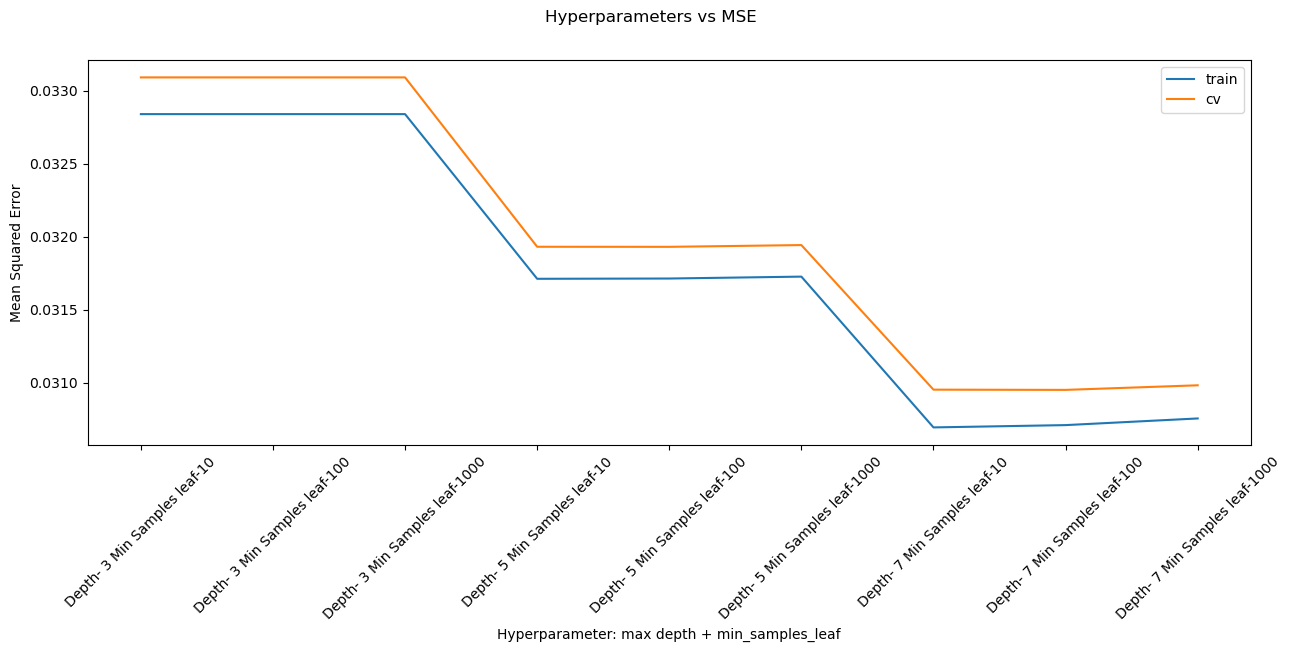

In [66]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

*Feature Importance*

In [67]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.404480
idiot,0.268527
fool,0.072519
pathet,0.069021
moron,0.064452
white,0.058229
hypocrit,0.055104
racist,0.004977
ignor,0.000730
trump,0.000725


*LSTM*

- Long-short term memory is a type of Recurrent Neural Network (RNN).
- It is designed to overcome the "vanishing gradient problem" and "exploding" that is in traditional RNN, this allows it to capture long range dependencies in sequential data. 
- It consists of three gates called forget, input and output gate that cintrols the flow of information through a cell. 
- The forget gate decides what information fron the previous time step should be discarded.
- It takes as input the previous cell state and the current input, and outputs a value between 0 and 1 for each component of the cell state.
- The input gate decides what information from the current input should be stored. It takes as input the previous cell state and the current input, and outputs a candidate value to be added to the cell state.
- The output gate controls what information from the cell state should be passed to the next time step as output.
- It takes as input the current input and the current cell state, and produces the output of the LSTM cell.
_ LSTM are mostly used in natural language processing, time series prediction, text generation, speech recognition etc.


In [68]:
# creating a class called "LSTMFeaturization" that preprocesses text data for input into LSTM
class LSTMFeaturization:
    
    # initializing two attributes to store the word mappings and the total number of unique words in the vocabulary. 
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    # defining a function that takes a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        # Initialize an empty set to store unique words.
        vocab = set()
        
        # Iterate through each sentence in the list of sentences.
        for x in sentences:
            
            # Split the sentence into words and add each word to the vocabulary set.
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from the vocabulary set with initial count set to 0 for each word.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate the count of each word in the sentences.
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
        
        # returns a dictionary
        # keys are unique words found in the list and values are count of each word occurence in the sentence        
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocab_dict) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
        
        # Separate keys (words) and values (counts) from the vocabulary dictionary.        
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
        
        # Stack keys and values vertically to form a 2D array.    
        kv = np.vstack((k,v)).T
        
        # Create a DataFrame from the 2D array with columns "Word" and "Count".
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the DataFrame by count in descending order to get the most frequent words first.
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Reset the index of the DataFrame.
        df.reset_index(inplace=True)
        
         # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df['mapping'] = df.index + 1
        
        # Drop the index column and count column from the DataFrame.
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        # returns a dictionary
        # where keys are words and values are their mapping numbers
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        
        # Build vocabulary from the list of sentences.
        v = self.build_vocabulary(sentences)
        
        # Get word mappings from the vocabulary dictionary.
        self.word_mapping = self.get_mapping(v)
        
        # Store the total number of unique words.
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        
        # Iterate through each sentence in the list of sentences.
        for x in sentences: 
            part = list()
            
            # Iterate through each word in the sentence.
            for word in x.split():
                
                # If the word is in the word mapping, append its mapped number to the list.
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
                    
            # Append the list of mapped numbers for the sentence to the whole list.
            whole.append(part) 
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [69]:
# Create an instance of the LSTMFeaturization class
lstmfeat = LSTMFeaturization()

# Fit the featurizer to the preprocessed text data in the training set to build vocabulary and generate word mappings
lstmfeat.fit(X_train['preprocessed_text'])

In [70]:
# Transform the preprocessed text data in the training set into numerical sequences using the fitted LSTMFeaturization object
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [71]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [72]:
# Save the processed LSTM features of the data to a NumPy binary file
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [73]:
# we are creating a neural network model. 
# the model consists of 1 embedding layer, two LSTM layers and one dense output layer
# The embedding layer transforms integer-encoded word indices into dense vectors of fixed size.
# The final dense layer produces a single output representing the sentiment prediction for each input sentence.
# The model is compiled with a mean squared error loss function, rmsprop optimizer, and mean squared error metric for evaluation.


# Set the dimensionality of the embedding vector to 100
embedding_vecor_length = 100

# Get the total number of unique words in the vocabulary from the LSTMFeaturization object
total_words = lstmfeat.total_words

# Initialize a sequential model
model = Sequential()

# Add an embedding layer with the specified input dimensionality, output dimensionality, and input length
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))

# Add a LSTM layer with 128 units and return sequences
model.add(LSTM(128, return_sequences=True))

# Add another LSTM layer with 128 units
model.add(LSTM(128))

# Add a dense layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with mean squared error loss function, rmsprop optimizer, and mean squared error metric
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

# Print the model summary which displays the architecture and parameter count
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20178900  
                                                                 
 lstm (LSTM)                 (None, 350, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20427861 (77.93 MB)
Trainable params: 20427861 (77.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [74]:
# Define the filepath pattern for saving the best model weights during training.
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

# Define a callback to save the best model weights based on validation loss.
# ModelCheckpoint monitors the validation loss, verbose=1 displays progress, save_best_only=True saves only the best model,
# and mode='max' specifies that higher validation loss is better.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

# Create a list of callbacks containing the ModelCheckpoint callback.
callbacks_list = [checkpoint]

In [ ]:
# Train the model using the fit function.
# The `lstm_train` data is used as input features, `y_train` as target labels.
# nb_epoch=5 specifies the number of epochs (iterations over the entire dataset) for training.
# batch_size=2048 determines the number of samples per gradient update.
# validation_data=(lstm_cv, y_cv) provides data for validation during training.
# verbose=1 displays progress during training (1 for progress bar, 0 for silent).
# callbacks=callbacks_list specifies the list of callbacks to be used during training, including model checkpoint.

history = model.fit(lstm_train, y_train, epochs=4,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Text(0.5, 1.0, 'Loss Curves')

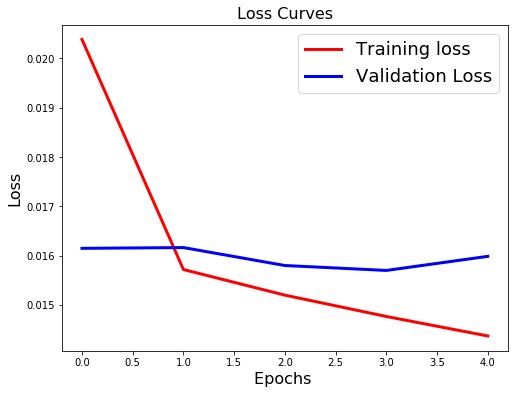

In [ ]:
# plot to visualize the training and validation loss curves over epochs
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l1
        - Train MSE Loss: 0.0231
        - CV MSE Loss: 0.0230
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0309
        - CV MSE Loss: 0.03122
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l1
        - Train MSE Loss: 0.02525
        - CV MSE Loss: 0.02542
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03070
        - CV MSE Loss: 0.03095
3. **LSTM:**
    - Train MSE Loss: 0.0157
    - CV MSE Loss: 0.0162